#  Clusters Unifying Through Hiding Interpolation (CUTHI) 
Benmoshe, N. (2025). A Simple Solution for the Inverse Distance Weighting Interpolation (IDW) Clustering Problem. Sci, 7(1), 30.‏

In [16]:
def cuthi(x, y, stations, s=0.5, alpha=2):
    for i in range(len(stations)):
        if stations[i][0] == x and stations[i][1] == y:
            return stations[i][2]

    wtotal=0
    for k in range(len(stations)):
        r = ((stations[k,0]-x)**2+(stations[k,1]-y)**2)  # it's r^2
        if r!=0:
            w=1./r**(alpha/2)
            wcuthi = 1.
            for m in range(len(stations)):
                adist2 = float((stations[k][0] - stations[m][0]) ** 2 + (stations[k][1] - stations[m][1]) ** 2)
                bdist2 = float((stations[m][0] - x) ** 2 + (stations[m][1] - y) ** 2)
                if adist2>0 and bdist2>0:
                    cosgama = (adist2 + bdist2 - r) / (2.0 * adist2**.5 * bdist2**.5)
                    nangle = ((cosgama+1.)/2.)
                    if nangle<0:
                        if nangle<-0.01:
                            print ('nangle ngnalge')
                        else:
                            nangle = 0.
                            
                    wcuthi*=nangle**s
            w = w*wcuthi        
            wtotal+=w
    res=0
    for k in range(len(stations)):
        r = ((stations[k,0]-x)**2+(stations[k,1]-y)**2)
        if r == 0:
            res = stations[k,2]
        else:
            w=1./r**(alpha/2)
            wcuthi=1.
            for m in range(len(stations)):
                adist2 = float((stations[k][0] - stations[m][0]) ** 2 + (stations[k][1] - stations[m][1]) ** 2)
                bdist2 = float((stations[m][0] - x) ** 2 + (stations[m][1] - y) ** 2)
                if adist2>0 and bdist2>0:
                    cosgama = (adist2 + bdist2 - r) / (2.0 * adist2**.5 * bdist2**.5)
                    nangle = ((cosgama+1.)/2.)
                    if nangle<0:
                        if nangle<-0.01:
                            print ('nangle ngnalge')
                        else:
                            nangle = 0.
                    wcuthi*=nangle**s
            w = w*wcuthi
            res+=stations[k,2]*w/wtotal
    return res

# Inverse distance Weighting (IDW)
Shepard, D. A two-dimensional interpolation function for irregularly-spaced data. In Proceedings of the 1968 23rd ACM National Conference, Las Vegas, NV, USA, 27–29 August 1968; ACM: New York, NY, USA, 1968; pp. 517–524.

In [17]:
def idw(x, y, stations, alpha=2):
   
    # Check for exact match first (avoiding all the loops if found)
    idx = np.where((stations[:, 0] == x) & (stations[:, 1] == y))
    if idx[0].size > 0:
        return stations[idx[0][0], 2]
    
    # Precompute distances between all stations and the point (x, y)
    dx = stations[:, 0] - x
    dy = stations[:, 1] - y
    r2 = dx**2 + dy**2  # r^2
    
    # Calculate total weight
    wtotal = np.sum(1. / r2**(alpha / 2))
    
    # If wtotal is 0, return 0 (or handle this case according to your needs)
    if wtotal == 0:
        return 0
    
    # Weighted sum of station values
    w = 1. / r2**(alpha / 2)
    res = np.sum(stations[:, 2] * w / wtotal)
    
    return res

# Nearest station

In [18]:
def nearest(i,j,stations):
    rmin=9e99
    val=0
    for k in range(len(stations)):
        r = ((stations[k,0]-j)**2+(stations[k,1]-i)**2)**0.5
        if r<rmin:
            rmin=r
            val = stations[k,2]    
    return val

# Cross-validation code

In [19]:
import sklearn.metrics
def crossvalidation(stations, method = "cuthi", alpha = 2):
    size=len(stations)
    r2 = 0
    resultcuthi = []
    for i in range(size):
            cv = []
            for j in range(size):
                if i!=j:
                   cv.append(stations[j])                      
            cv = np.asarray(cv)
            if method=="cuthi":
                resultcuthi.append(cuthi(stations[i,0],stations[i,1],cv, s=0.5, alpha=alpha))
            elif method=="idw":
                resultcuthi.append(idw(stations[i,0],stations[i,1],cv,alpha=alpha))
            elif method=="nearest":
                resultcuthi.append(nearest(stations[i,0],stations[i,1],cv))
    r2   += sklearn.metrics.r2_score(stations[:,2], resultcuthi)
    return r2

# Build the stations data #

In [20]:
import random 
import numpy as np
def getFunction(size):
    minlat = -50
    maxlat = 150
    minlng = -50
    maxlng = 150
    
    stations = []
    for i in range (size):
        latrand = random.uniform(minlat, maxlat)
        lngrand = random.uniform(minlng, maxlng)
        z = latrand **2 - lngrand **2
        stations.append([lngrand, latrand, z])
    stations = np.asarray(stations)
    
    return stations

# Main code
1. build the station data (using mathematical function)
2. interpolation
3. calculate the CUTHI accuracy using cross-validation (optional) - it is better to use interpolation only if the score is positive

In [23]:
size=40
stations = getFunction(size)
resultcuthi = cuthi(0,0,stations)
print("Interpolated value of x=0, y=0 (should be 0, maximum value is 22500) is:", resultcuthi)
print("Cross validation score should be positive, if it is negative, it is better to use average values rather than interpolation.")
print("IDW Cross validation score is            :",crossvalidation(stations, method="idw"))
print("CUTHI Cross validation score is          :",crossvalidation(stations, method="cuthi"))
print("Nearest station Cross validation score is:",crossvalidation(stations, method="nearest"))

Interpolated value of x=0, y=0 (should be 0, maximum value is 22500) is: 45.10450561427898
Cross validation score should be positive, if it is negative, it is better to use average values rather than interpolation.
IDW Cross validation score is            : 0.8022928587613779
CUTHI Cross validation score is          : 0.9533022111917642
Nearest station Cross validation score is: -3.1667046486576247


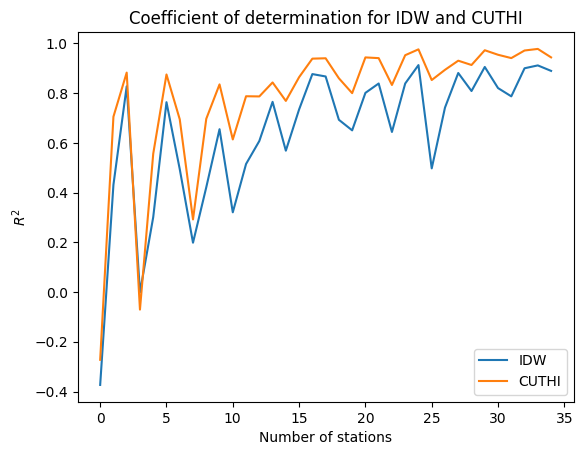

In [22]:
import matplotlib.pyplot as plt
cvidw=[]
cvcuthi=[]
cvnearest=[]
for size in range(5, 40):
    stations = getFunction(size)
    cvidw.append(crossvalidation(stations, method="idw"))
    cvcuthi.append(crossvalidation(stations, method="cuthi"))
    cvnearest.append(crossvalidation(stations, method="nearest"))
plt.figure()
plt.plot(cvidw,label='IDW')
plt.plot(cvcuthi,label='CUTHI')
#plt.plot(cvnearest,label='NEAREST')
plt.xlabel('Number of stations')
plt.ylabel('$R^2$')
plt.title('Coefficient of determination for IDW and CUTHI')
plt.legend()
plt.show()